# import modules

In [2]:
import sys

sys.path.insert(0, "../")

from modules.Classes_ver2 import *
from modules.default_params_ver1 import *
from modules.functions_ver2 import *

# assign params

In [3]:
lens_params, NP_params = set_to_params(lens_params_1, NP_params_1)

# optimize mismatch between NP templates and L source over $\mathcal{M}_{\text{t}}$

# define functions

In [20]:
mcz_arr = np.linspace(10, 90, 250)


def mismatch_NP_L_plot(t_params, s_params, psd=None):
    results = {}
    ep_arr = np.zeros(len(mcz_arr))
    opt_ep_arr = np.zeros(len(mcz_arr))
    opt_ep_mcz_arr = np.zeros(len(mcz_arr))

    inst = LensingGeo(s_params)
    td = inst.td()
    I = inst.I()

    for i, mcz_L in enumerate(mcz_arr):
        s_params["mcz"] = t_params["mcz"] = mcz_L * solar_mass

        ep_NP_L = mismatch(t_params, s_params)["mismatch"]
        ep_arr[i] = ep_NP_L

        opt_ep_results = optimize_mismatch_mcz(t_params, s_params)
        opt_ep_arr[i] = opt_ep_results["ep_min"]
        opt_ep_mcz_arr[i] = opt_ep_results["ep_min_mcz"]

    ep_arr = omit_numerical_errors(ep_arr)
    results = {
        "mcz_arr": mcz_arr,
        "ep_arr": ep_arr,
        "opt_ep_arr": opt_ep_arr,
        "opt_ep_mcz_arr": opt_ep_mcz_arr,
    }

    # plot mismatch vs mcz
    plt.plot(mcz_arr, results["ep_arr"], label=r"$\epsilon$", ls="-", c="black")
    plt.plot(
        mcz_arr,
        results["opt_ep_arr"],
        label=r"$\min_{\mathcal{M}_{\rm t}}$ $\epsilon$",
        ls="--",
        c="red",
    )

    mcz_vertical = (
        (s_params["eta"] ** (3 / 5))
        / (6 ** (3 / 2) * np.pi * (20 + 1 / td))
        / solar_mass
    )
    plt.axvline(x=mcz_vertical, c="blue", ls="-", alpha=0.5)

    ep_horizontal = 1 - (1 + I) ** (-1 / 2)
    plt.axhline(y=ep_horizontal, c="grey", ls=":")

    plt.xlabel(r"$\mathcal{M}_{\text{s}}$ $[M_{\odot}]$")
    plt.ylabel(r"$\epsilon(\~h_{\rm UL}, \~h_{\rm L})$")
    plt.legend()

    # plt.title(
    #     r"$\theta_S$ = {}, $\phi_S$ = {}, $\theta_J$ = {}, $\phi_J$ = {}, {} = {:.3g} {}, $\Delta t_d$ = {:.3g} ms, $I$ = {:.3g}".format(
    #         angle_in_pi_format(s_params["theta_S"]),
    #         angle_in_pi_format(s_params["phi_S"]),
    #         angle_in_pi_format(s_params["theta_J"]),
    #         angle_in_pi_format(s_params["phi_J"]),
    #         r"$\mathcal{M}_{\rm s}$",
    #         s_params["mcz"] / solar_mass,
    #         r"$M_{\odot}$",
    #         td * 1e3,
    #         I,
    #     )
    # )

    # plt.suptitle(
    #     r"Mismatch Between Unlensed Templates & a Lensed Source Optimized Over $\mathcal{M}_{\rm t}$"
    # )

    return results

In [21]:
def predict_epsilon_critical_points(s_params):
    eta = s_params["eta"]
    inst = LensingGeo(s_params)
    td = inst.td()
    I = inst.I()
    f_min = 20

    # peaks of epsilon
    n_peak = math.ceil(f_min * td)
    mcz_peak = (eta ** (3 / 5) * td) / (6 ** (3 / 2) * np.pi * n_peak) / solar_mass
    while mcz_peak >= 10:
        if mcz_peak <= 90:
            plt.axvline(x=mcz_peak, c="pink", ls="-.")
        n_peak += 1
        mcz_peak = (eta ** (3 / 5) * td) / (6 ** (3 / 2) * np.pi * n_peak) / solar_mass

    # troughs of epsilon
    n_trough = math.ceil(f_min * td - 1 / 2)
    mcz_trough = (
        (eta ** (3 / 5) * td) / (6 ** (3 / 2) * np.pi * (n_trough + 1 / 2)) / solar_mass
    )
    while mcz_trough >= 10:
        if mcz_trough <= 90:
            plt.axvline(x=mcz_trough, c="cyan", ls=":")
        n_trough += 1
        mcz_trough = (
            (eta ** (3 / 5) * td)
            / (6 ** (3 / 2) * np.pi * (n_trough + 1 / 2))
            / solar_mass
        )

In [22]:
def predict_epsilon_flat_points(s_params):
    eta = s_params["eta"]
    inst = LensingGeo(s_params)
    td = inst.td()
    I = inst.I()
    f_min = 20

    n = 0
    mcz_flat = (
        (s_params["eta"] ** (3 / 5))
        / (6 ** (3 / 2) * np.pi * (f_min + n / td))
        / solar_mass
    )
    while mcz_flat >= 10:
        if mcz_flat <= 90:
            plt.axvline(x=mcz_flat, c="green", ls=":")
        n += 1
        mcz_flat = (
            (s_params["eta"] ** (3 / 5))
            / (6 ** (3 / 2) * np.pi * (f_min + n / td))
            / solar_mass
        )

# plot mismatch optimized over $\mathcal{M}_{\text{t}}$

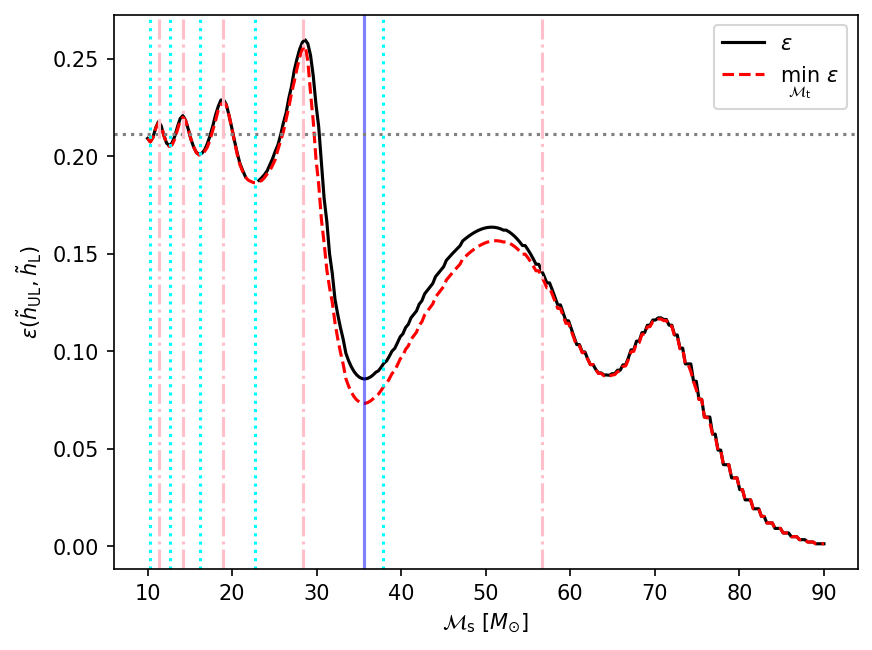

In [23]:
lens_params, NP_params = set_to_params(lens_params_1, NP_params_1)

mcz_arr = np.linspace(10, 90, 250)
MLz_arr = np.array([3e3])
mismatch_plots_dict = {}

for MLz in MLz_arr:
    lens_params["MLz"] = MLz * solar_mass
    mismatch_plots_dict[MLz] = mismatch_NP_L_plot(NP_params, lens_params)
    predict_epsilon_critical_points(lens_params)
    plt.savefig(
        "../figures/mismatch_NP_L_ML{:.4g}.pdf".format(MLz), bbox_inches="tight"
    )

# waveform comparison

In [30]:
from scipy.signal import argrelextrema


def waveform_comparison_modified(t_params, s_params):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    fig.subplots_adjust(wspace=0.25)

    updated_params = find_optimized_coalescence_params(t_params, s_params)
    t_params = updated_params["updated_t_params"]
    s_params = updated_params["updated_s_params"]
    epsilon = updated_params["updated_mismatch_results"]["mismatch"]
    idx = updated_params["updated_mismatch_results"]["index"]
    phi = updated_params["updated_mismatch_results"]["phi"]

    # template waveform
    t_gw = get_gw(t_params)
    t_phase = t_gw["phase"]

    axes[0].plot(
        t_gw["f_array"],
        np.abs(t_gw["strain"]),
        label="template",
        color="black",
        linestyle="-",
    )

    # source waveform
    s_gw = get_gw(s_params)
    s_phase = s_gw["phase"]

    axes[0].plot(
        s_gw["f_array"],
        np.abs(s_gw["strain"]),
        label="source",
        color="black",
        linestyle="--",
    )

    axes[0].legend(fontsize=20)
    axes[0].set_xlabel("f (Hz)", fontsize=24)
    axes[0].set_ylabel(r"$|\~{h}|$", fontsize=24)
    axes[0].tick_params(axis="both", which="major", labelsize=18)
    axes[0].set_title("Strain", fontsize=24)

    phase_diff = s_phase - t_phase
    # phase_diff = np.unwrap(phase_diff - phase_diff[0])
    phase_diff = np.unwrap(phase_diff)

    axes[1].plot(s_gw["f_array"], phase_diff, color="black", linestyle="-")

    # get Delta t_d and I
    lens_inst = LensingGeo(s_params)
    td = lens_inst.td()
    I = lens_inst.I()
    delta_t = t_gw["strain"].delta_t
    t_c = idx * delta_t
    f_cut = lens_inst.f_cut()

    # plot one cycle
    f_cut_1cycle = 1 / td + 20
    if f_cut_1cycle > f_cut:
        f_cut_1cycle = f_cut
    f_1cycle = np.arange(20, f_cut_1cycle, 0.25)
    s_gw_1cycle = np.abs(s_gw["strain"][s_gw["f_array"] <= f_cut_1cycle])
    phase_diff_1cycle = phase_diff[s_gw["f_array"] <= f_cut_1cycle]
    # Find peaks
    strain_peaks_idx = argrelextrema(s_gw_1cycle, np.greater)[0]
    phase_diff_peaks_idx = argrelextrema(phase_diff_1cycle, np.greater)[0]
    # Find troughs
    strain_troughs_idx = argrelextrema(s_gw_1cycle, np.less)[0]
    phase_diff_troughs_idx = argrelextrema(phase_diff_1cycle, np.less)[0]
    # Find inflection points
    # Calculate first derivative
    strain_first_derivative = np.gradient(s_gw_1cycle)
    phase_diff_first_derivative = np.gradient(phase_diff_1cycle)
    # Calculate second derivative
    strain_second_derivative = np.gradient(strain_first_derivative)
    phase_diff_second_derivative = np.gradient(phase_diff_first_derivative)
    # Find where the second derivative changes sign
    strain_inflections_idx = np.where(np.diff(np.sign(strain_second_derivative)))[0]
    phase_diff_inflections_idx = np.where(
        np.diff(np.sign(phase_diff_second_derivative))
    )[0]

    # plot s_gw_1cycle["strain"] and the peak, trough, and inflection point as red dots
    axes[0].plot(f_1cycle, s_gw_1cycle, "r--", label="1 cycle of lensed")
    axes[0].plot(f_1cycle[strain_peaks_idx], s_gw_1cycle[strain_peaks_idx], "r*")
    axes[0].plot(f_1cycle[strain_troughs_idx], s_gw_1cycle[strain_troughs_idx], "r*")
    axes[0].plot(
        f_1cycle[strain_inflections_idx], s_gw_1cycle[strain_inflections_idx], "r*"
    )
    axes[0].legend()

    axes[1].plot(f_1cycle, phase_diff_1cycle, "r-")
    axes[1].plot(
        f_1cycle[phase_diff_peaks_idx],
        phase_diff_1cycle[phase_diff_peaks_idx],
        "r*",
        label="peak",
    )
    axes[1].plot(
        f_1cycle[phase_diff_troughs_idx],
        phase_diff_1cycle[phase_diff_troughs_idx],
        "r*",
        label="trough",
    )
    axes[1].plot(
        f_1cycle[phase_diff_inflections_idx],
        phase_diff_1cycle[phase_diff_inflections_idx],
        "r*",
        label="inflection",
    )
    ############################################################################################################

    fig.suptitle(
        r"$\Delta t_d$ = {:.3g} ms, $I$ = {:.3g}, $\epsilon = {:.3g}$, idx = {:.3g}, $\phi_c$ = {:.3g}".format(
            td * 1e3, I, epsilon, idx, phi
        ),
        fontsize=24,
        y=1.02,
    )

    # axes[1].set_xscale("log")
    axes[1].set_xlabel("f (Hz)", fontsize=24)
    axes[1].set_ylabel(r"$\Phi_{\rm s} - \Phi_{\rm t}$ (rad)", fontsize=24)
    axes[1].tick_params(axis="both", which="major", labelsize=18)
    axes[1].set_title("Phase Difference", fontsize=24)

In [31]:
def waveform_comparison_slider(mcz):
    lens_params, NP_params = set_to_params(lens_params_1, NP_params_1)
    lens_params["MLz"] = 3000 * solar_mass
    lens_params["mcz"] = NP_params["mcz"] = mcz * solar_mass
    waveform_comparison_modified(NP_params, lens_params)


interact(waveform_comparison_slider, mcz=widgets.FloatSlider(min=10, max=90, step=0.5))

interactive(children=(FloatSlider(value=10.0, description='mcz', max=90.0, min=10.0, step=0.5), Output()), _do…

<function __main__.waveform_comparison_slider(mcz)>